Goal
- explore tulu paper's results and see if I could fit data mixture to eval results, visualize task input-output dependendices.


some todo:
1. think about how to normalize input/output.
2. think about normalize w.r.t. number of training tokens, data points.
 

In [1]:
import os
from rosemary import jpt_setup; jpt_setup()
from rosemary import plt_scaled_colobar_ax

import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/gpfs/u/scratch/PTFM/PTFMqngp/github/rosemary/src/rosemary/__init__.py:25: UserWarning: Install `torch` for functionalities dependent on torch
  warn(f'Install `torch` for functionalities dependent on torch')


In [2]:
instruct_datasets = [
    # human-authored
    'SuperNI',
    'CoT',
    'Flan V2',
    'Dolly',
    'Open Assistant 1',
    # gpt-generated
    'Self-instruct',
    'Unnatural Instructions',
    'Alpaca',
    'Code-Alpaca',
    'GPT4-Alpaca',
    'Baize',
    'ShareGPT',
]

p = len(instruct_datasets)

def encode_input(dataset):
    if dataset in ('LLaMa-13B', 'Vanilla LLaMa', ''):
        return [0]*p
    if dataset == 'Human mix':
        # FLAN V2, CoT, Dolly, and Open Assistant 1
        return [0,1,1,1,1,0,0,0,0,0,0,0]
    if dataset == 'H+GPT mix':
        # FLAN V2, CoT, Dolly, and Open Assistant 1, GPT4-Alpaca, Code-Alpaca, and ShareGPT.
        return [0,1,1,1,1,0,0,0,1,1,0,1]
    x = [0]*p
    i = instruct_datasets.index(dataset)
    x[i] = 1
    return x

In [3]:
data = [
    ['', 31.9, 35.2, 6.0, 9.0, 34.0, 33.3, 39.1, 9.5, 11.6, 18.3, None, None],
    ['SuperNI', 44.1, 43.4, 3.0, 4.0, 38.4, 1.9, 47.9, 7.1, 7.0, 11.7, 5.7, 18.3],
    ['CoT', 41.3, 42.5, 6.5, 27.5, 33.7, 31.3, 44.4, 8.5, 7.4, 17.3, 4.2, 22.4],
    ['Flan V2', 45.4, 47.1, 3.5, 13.0, 38.6, 36.1, 45.0, 8.3, 9.6, 12.9, 4.6, 22.4],
    ['Dolly', 38.0, 35.8, 5.0, 7.0, 27.2, 24.4, 43.6, 8.7, 11.1, 22.1, 12.7, 20.7],
    ['Open Assistant 1', 32.9, 29.7, 6.0, 6.5, 20.4, 29.5, 26.8, 7.8, 10.1, 20.4, 47.8, 23.8],
    ['Self-instruct', 35.7, 33.2, 4.0, 6.5, 29.9, 29.2, 35.4, 8.7, 6.2, 12.1, 7.5, 18.0],
    ['Unnatural Instructions', 42.9, 38.1, 3.5, 5.0, 31.4, 30.0, 36.3, 6.5, 10.3, 19.8, 8.2, 20.0],
    ['Alpaca', 41.5, 40.3, 7.0, 10.0, 32.6, 31.8, 31.2, 7.2, 13.2, 22.0, 21.1, 23.3],
    ['Code-Alpaca', 34.7, 34.5, 6.5, 7.5, 29.6, 30.5, 36.7, 10.5, 16.5, 29.2, 17.5, 22.6],
    ['GPT4-Alpaca', 42.6, 38.3, 6.5, 10.0, 28.5, 32.3, 23.6, 5.8, 13.2, 25.0, 57.0, 28.3],
    ['Baize', 40.3, 38.6, 3.5, 5.5, 30.6, 32.4, 29.8, 7.9, 12.2, 23.8, 23.5, 22.6],
    ['ShareGPT', 44.3, 40.0, 8.0, 9.5, 5.2, 32.6, 25.5, 8.9, 10.9, 21.6, 58.3, 26.9],
    ['Human mix', 46.2, 48.0, 4.5, 26.5, 35.6, 34.8, 42.2, 7.7, 9.4, 20.2, 29.4, 27.8],
    ['H+GPT mix', 44.5, 47.0, 6.0, 27.0, 38.1, 39.2, 45.7, 7.7, 17.5, 27.8, 48.3, 33.1]
]

evals = [
    ('MMLU', '0-shot'),
    ('MMLU', '5-shot'),
    ('GSM', 'Direct'),
    ('GSM', 'CoT'),
    ('BBH', 'Direct'),
    ('BBH', 'CoT'),
    ('TydiQA', 'GP'),
    ('TydiQA', 'CB'),
    ('Codex-Eval', 'P@1'),
    ('Codex-Eval', 'P@10'),
    ('AlpacaFarm', 'v Davinci-003'),
]

cols = [('Instruction Dataset', '')] + evals + [('Average', '')]
multi_columns = pd.MultiIndex.from_tuples(cols)
df = pd.DataFrame(data, columns=multi_columns)
df.insert(0, ('Base Model', ''), 'llama7b')

## verify the numbers copied from pdf, processed by chatgpt is correct.
avg_major_column = df[evals].groupby(level=0, axis=1).mean()
avg_row = avg_major_column.mean(axis=1)
assert np.nanmean(avg_row.to_numpy() - df[('Average', '')].to_numpy())<0.01
df = df.drop(columns=[('Average','')])
##

df

Base Model     Instruction Dataset   MMLU           GSM          BBH        \
                                      0-shot 5-shot Direct   CoT Direct   CoT   
0     llama7b                           31.9   35.2    6.0   9.0   34.0  33.3   
1     llama7b                 SuperNI   44.1   43.4    3.0   4.0   38.4   1.9   
2     llama7b                     CoT   41.3   42.5    6.5  27.5   33.7  31.3   
3     llama7b                 Flan V2   45.4   47.1    3.5  13.0   38.6  36.1   
4     llama7b                   Dolly   38.0   35.8    5.0   7.0   27.2  24.4   
5     llama7b        Open Assistant 1   32.9   29.7    6.0   6.5   20.4  29.5   
6     llama7b           Self-instruct   35.7   33.2    4.0   6.5   29.9  29.2   
7     llama7b  Unnatural Instructions   42.9   38.1    3.5   5.0   31.4  30.0   
8     llama7b                  Alpaca   41.5   40.3    7.0  10.0   32.6  31.8   
9     llama7b             Code-Alpaca   34.7   34.5    6.5   7.5   29.6  30.5   
10    llama7b             GPT4-Alpaca   42.6   38.3    6.5  10.0   28.5  32.3   
11    llama7b                   Baize   40.3   38.6    3.5   5.5   30.6  32.4   
12    llama7b                ShareGPT   44.3   40.0    8.0   9.5    5.2  32.6   
13    llama7b               Human mix   46.2   48.0    4.5  26.5   35.6  34.8   
14    llama7b               H+GPT mix   44.5   47.0    6.0  27.0   38.1  39.2   

   TydiQA       Codex-Eval          AlpacaFarm  
       GP    CB        P@1  P@10 v Davinci-003  
0    39.1   9.5       11.6  18.3           NaN  
1    47.9   7.1        7.0  11.7           5.7  
2    44.4   8.5        7.4  17.3           4.2  
3    45.0   8.3        9.6  12.9           4.6  
4    43.6   8.7       11.1  22.1          12.7  
5    26.8   7.8       10.1  20.4          47.8  
6    35.4   8.7        6.2  12.1           7.5  
7    36.3   6.5       10.3  19.8           8.2  
8    31.2   7.2       13.2  22.0          21.1  
9    36.7  10.5       16.5  29.2          17.5  
10   23.6   5.8       13.2  25.0          57.0  
11   29.8   7.9       12.2  23.8          23.5  
12   25.5   8.9       10.9  21.6          58.3  
13   42.2   7.7        9.4  20.2          29.4  
14   45.7   7.7       17.5  27.8          48.3

In [4]:

def shorten_dataset_name(x):
    x = x.replace('-', '')
    x = x.replace(' ', '')
    x = x.lower()
    if x == 'alpaca':
        x = 'stanfordalpaca'
    if x == 'openassistant1':
        x = 'oasst1'
    return x
df['Instruction Dataset'].map(shorten_dataset_name).to_list()

['',
 'superni',
 'cot',
 'flanv2',
 'dolly',
 'oasst1',
 'selfinstruct',
 'unnaturalinstructions',
 'stanfordalpaca',
 'codealpaca',
 'gpt4alpaca',
 'baize',
 'sharegpt',
 'humanmix',
 'h+gptmix']

In [5]:
dfc = df.copy()
def shorten_dataset_name(x):
    x = x.replace('-', '')
    x = x.replace(' ', '')
    x = x.lower()
    return x
dfc['Instruction Dataset'] = dfc['Instruction Dataset'].map(shorten_dataset_name)
dfc.columns = [f'{x}/{y}' if y else x for x,y in dfc.columns]
# dfc['Base Model'] + '_' + dfc['Instruction Dataset']
dfc.insert(0, 'Model', dfc.apply(lambda r: f"{r['Base Model']}" if not r['Instruction Dataset']
          else f"{r['Base Model']}+{r['Instruction Dataset']}", axis=1))
dfc['Model'] = dfc['Model'].astype(str) + ' (Paper)'
# dfc = dfc[dfc['Instruction Dataset'].isin(['', 'Human mix', 'H+GPT mix'])]
dfc = dfc[~dfc['Instruction Dataset'].isin(['unnaturalinstructions'])]

dfc = dfc.drop(columns=['Base Model', 'Instruction Dataset'])
dfc = dfc[['Model', 'MMLU/0-shot', 'GSM/CoT', 'BBH/Direct', 'Codex-Eval/P@1']] # 'BBH/CoT', 
#display(dfc.style.format(precision=1))
display(dfc.style.background_gradient(cmap ='coolwarm').format(precision=1))


,Model,MMLU/0-shot,GSM/CoT,BBH/Direct,Codex-Eval/P@1
0,llama7b (Paper),31.9,9.0,34.0,11.6
1,llama7b+superni (Paper),44.1,4.0,38.4,7.0
2,llama7b+cot (Paper),41.3,27.5,33.7,7.4
3,llama7b+flanv2 (Paper),45.4,13.0,38.6,9.6
4,llama7b+dolly (Paper),38.0,7.0,27.2,11.1
5,llama7b+openassistant1 (Paper),32.9,6.5,20.4,10.1
6,llama7b+selfinstruct (Paper),35.7,6.5,29.9,6.2
8,llama7b+alpaca (Paper),41.5,10.0,32.6,13.2
9,llama7b+codealpaca (Paper),34.7,7.5,29.6,16.5
10,llama7b+gpt4alpaca (Paper),42.6,10.0,28.5,13.2


In [6]:

evals_subset = [
    ('MMLU', '0-shot'),
    ('MMLU', '5-shot'),
    ('GSM', 'Direct'),
    ('GSM', 'CoT'),
    ('BBH', 'Direct'),
    ('BBH', 'CoT'),
    ('TydiQA', 'GP'),
    ('TydiQA', 'CB'),
    ('Codex-Eval', 'P@1'),
    ('Codex-Eval', 'P@10'),
#     ('AlpacaFarm', 'v Davinci-003'),
]
output_names = [f'{x}_{y}' for x, y in evals_subset]

dfs = df.copy()
dfs = dfs[evals_subset]
dfs.columns = output_names
dfs

,MMLU_0-shot,MMLU_5-shot,GSM_Direct,GSM_CoT,BBH_Direct,BBH_CoT,TydiQA_GP,TydiQA_CB,Codex-Eval_P@1,Codex-Eval_P@10
0,31.9,35.2,6.0,9.0,34.0,33.3,39.1,9.5,11.6,18.3
1,44.1,43.4,3.0,4.0,38.4,1.9,47.9,7.1,7.0,11.7
2,41.3,42.5,6.5,27.5,33.7,31.3,44.4,8.5,7.4,17.3
3,45.4,47.1,3.5,13.0,38.6,36.1,45.0,8.3,9.6,12.9
4,38.0,35.8,5.0,7.0,27.2,24.4,43.6,8.7,11.1,22.1
5,32.9,29.7,6.0,6.5,20.4,29.5,26.8,7.8,10.1,20.4
6,35.7,33.2,4.0,6.5,29.9,29.2,35.4,8.7,6.2,12.1
7,42.9,38.1,3.5,5.0,31.4,30.0,36.3,6.5,10.3,19.8
8,41.5,40.3,7.0,10.0,32.6,31.8,31.2,7.2,13.2,22.0
9,34.7,34.5,6.5,7.5,29.6,30.5,36.7,10.5,16.5,29.2


In [ ]:
X = [encode_input(x[0]) for x in data]
X = np.array(X)
y = dfs.to_numpy()

X_train = X[:-2]
y_train = y[:-2]

X_test = X[-2:]
y_test = y[-2:]

# `y` is the performance delta between base model and instruction tuned model 
base_model_perf = y_train[0,:].copy()
y_train = y_train-base_model_perf
X_train = X_train[1:]; y_train = y_train[1:]
y_test = y_test-base_model_perf

print(X_train)
print(y_train)
print(X_test)
print(y_test)

In [16]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge, ElasticNet, Lasso
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso

reg = MultiOutputRegressor(ElasticNet(
    random_state=123, 
    fit_intercept=True,
    alpha=.01,
    l1_ratio=.5,
))
reg.fit(X_train, y_train)
reg

MultiOutputRegressor(estimator=ElasticNet(alpha=0.01, random_state=123))

MSE: 76.14


<Axes: title={'center': 'Compare `y_pred` and `y_test` '}, ylabel='y_pred           y_test'>

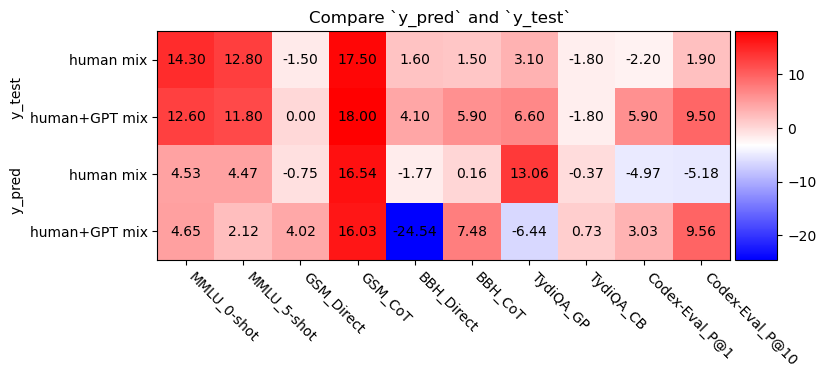

In [17]:
from rosemary import plt_kernel_matrix_one

y_pred = reg.predict(X_test)
print(f'MSE: {sklearn.metrics.mean_squared_error(y_test, y_pred):.2f}')

fig, ax = plt.subplots(1,1,figsize=(8,4))
y_test_pred = np.vstack([y_test, y_pred])
plt_kernel_matrix_one(fig, ax, y_test_pred, custom_ticks=False, annotate=True, cmap='bwr')
ax.set_ylabel('y_pred           y_test')
ax.set_xticks(list(range(len(output_names))), output_names, rotation=-45, ha='left')
ylabels = ['human mix', 'human+GPT mix']*2
ax.set_yticks(list(range(len(ylabels))), ylabels)

ax.set_title('Compare `y_pred` and `y_test` ')
ax

In [18]:
W = np.stack([reg.estimators_[i].coef_ for i in range(len(reg.estimators_))]).T
b = np.stack([reg.estimators_[i].intercept_ for i in range(len(reg.estimators_))]).T

with np.printoptions(precision=2, suppress=True):
    print(W.shape, b.shape)
    print(W)
    print('intersept:  ', b)
    print('base model: ', [31.9,35.2,6.0,9.0,34.0,33.3,11.6])

(12, 10) (10,)
[[  3.37   4.61  -2.07  -4.81   8.66 -25.66  11.63  -0.79  -3.38  -7.77]
 [  0.73   3.76   1.12  17.25   4.22   1.97   8.33   0.42  -3.    -2.49]
 [  4.59   8.1   -1.6    3.57   8.85   6.5    8.9    0.23  -0.93  -6.64]
 [ -2.27  -2.45  -0.18  -1.98  -1.8   -4.43   7.58   0.61   0.37   1.93]
 [ -7.09  -8.2    0.65  -2.45  -8.21   0.27  -8.16  -0.13  -0.46   0.32]
 [ -4.44  -4.9   -1.12  -2.45   0.64   0.    -0.05   0.61  -4.14  -7.39]
 [  2.24  -0.28  -1.6   -3.87   2.05   0.74   0.69  -1.35  -0.27  -0.13]
 [  0.91   1.69   1.59   0.74   3.19   2.44  -4.01  -0.69   2.35   1.83]
 [ -5.39  -3.67   1.12  -1.51   0.36   1.21   1.07   2.31   5.47   8.63]
 [  1.95  -0.09   1.12   0.74  -0.57   2.91 -11.18  -2.01   2.35   4.66]
 [ -0.1    0.08  -1.6   -3.4    1.3    3.01  -5.33  -0.03   1.41   3.53]
 [  3.56   1.4    2.54   0.26 -22.55   3.19  -9.39   0.8    0.18   1.46]]
intersept:   [ 8.57  3.25 -0.75  0.16 -4.84 -4.15 -3.59 -1.51 -0.96  1.7 ]
base model:  [31.9, 35.2, 6.0, 9.

<Axes: xlabel='Output', ylabel='Input'>

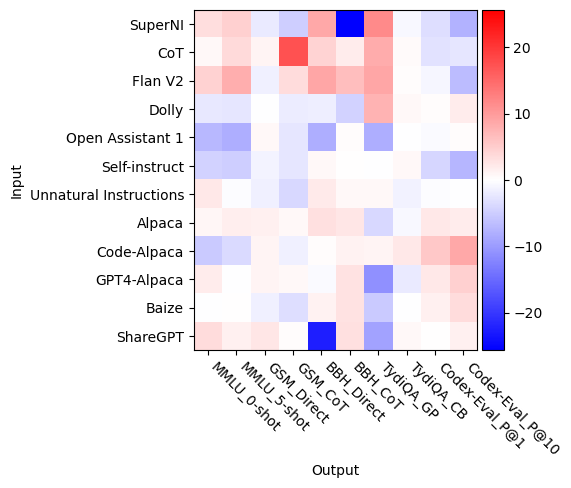

In [19]:
fig, ax = plt.subplots(1,1,figsize=(4,7))
v = max(abs(W.max()), abs(W.min()))
im = ax.imshow(W, cmap='bwr', vmin=-v, vmax=v)
fig.colorbar(im, cax=plt_scaled_colobar_ax(ax))
ax.set_ylabel('Input')
ax.set_xlabel('Output')
ax.set_yticks(list(range(len(instruct_datasets))), instruct_datasets)
ax.set_xticks(list(range(len(output_names))), output_names, rotation=-45, ha='left')
ax